## Как учатся машины

Предположим, мы хотим определить цену машины по таким параметрам:

- пробег
- мощность в лошадиных силах,
- тип топлива,
- потребление топлива (литров за 1 км) 
- количество дверей,
 
Кажется, цена может быть линейно связана с каким-то показателем (например, с потреблением топлива)
price = a + b * l/km

Как найти a и b?  Это - параметры прямой (от них будет зависеть ее наклон и положение в пространстве)

Какая линия -- лучшая? Лучшая линия -- та, которая отражает положение данных. С одним параметром это не сложно, но у нас много параметров:
price = a + b * пробег + c * мощность + d * топливо + e * двери

Пространоство признаков стало многомерным,и вместо прямой, положение данных будет отражает другое подпространство. Задача алгоритма во время обучения -- подобрать наилучшее подпространство

## Overfitting, Underfitting

<img alt="overfitting and underfitting" src="https://www.oreilly.com/library/view/deep-learning/9781491924570/assets/dpln_0107.png">



Как избавиться от переобучения (overfitting)

- Cross-validation
- Train with more data
- Early stopping
- Regularization
- Ensembling


Как избавиться от недообучения (underfitting)

- увеличить набор параметров в модели
- выбрать другой алгоритм
- увеличить время обучения и выбрать другую функцию ошибок

## Cost Function

<img alt="" class="ur vg fi fu fr kw v c" width="405" height="417" role="presentation" src="https://miro.medium.com/max/810/1*UUHvSixG7rX2EfNFTtqBDA.gif" srcset="https://miro.medium.com/max/552/1*UUHvSixG7rX2EfNFTtqBDA.gif 276w, https://miro.medium.com/max/810/1*UUHvSixG7rX2EfNFTtqBDA.gif 405w" sizes="405px">



([подробнее про cost function](https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220))

## практическая часть

In [1]:
# import os
import numpy as np
import pandas as pd
pd.set_option('max_columns', None) # не "прячет" колонки датафрейма

import matplotlib.pyplot as plt
import seaborn
 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model

In [4]:
import warnings
warnings.filterwarnings('ignore') # так можно "спрятать" warnings

In [5]:
from sklearn.datasets import make_classification # генерация рандомного датасета для классификации


### создание своего датасета (random seed, data exploration)

подробнее про [make classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [36]:
X, y = make_classification(n_classes=2,
    weights=[0.7, 0.3], # proportions of samples assigned to each class
                           
    n_informative=40, n_redundant=45, n_features=200, 
    n_clusters_per_class=4, 
    n_samples=1000, random_state=4) #np.random.randint(10000)

In [39]:
# display(X.shape)
X[:5, :4] # смотрим на часть матрицы признаков, а вообще она большая

array([[ 0.66794613, -0.44650395,  5.64069283, -0.28023025],
       [-2.33136302,  2.49864479,  8.31145909, -0.75826268],
       [ 2.51575636,  0.34813661, -7.31985531, -0.53124425],
       [-0.23757112,  1.26118129, -8.42500608, -0.95282484],
       [ 0.27468395,  1.22836553,  6.83314928,  1.19859023]])

In [44]:
X

array([[ 0.66794613, -0.44650395,  5.64069283, ...,  0.37441215,
         1.80151824,  0.71404462],
       [-2.33136302,  2.49864479,  8.31145909, ..., -1.83784593,
        -0.59042351,  0.36753982],
       [ 2.51575636,  0.34813661, -7.31985531, ..., -1.93152467,
         1.75658597,  0.25264347],
       ...,
       [ 0.63656851,  0.94564521, 10.81352631, ..., -0.63745901,
         0.18695114,  1.27644682],
       [ 1.55457048, -1.87700709, -0.59571896, ...,  0.10776207,
        -1.37377115, -1.22012357],
       [ 4.49609286,  0.09211852,  3.51117038, ...,  0.42809229,
         0.33226187,  0.75267691]])

In [42]:
display(y.shape)

y[:5] # часть вектора, каждое значение - это класс отдельного объекта 

(1000,)

array([1, 0, 1, 1, 1])

Теперь у нас есть матрица (X) с признаками и весами этих признаков, а еще есть вектор (y), определяющий каждый семпл в отдельный класс. Давайте посмотрим на признаки

In [45]:
features = pd.DataFrame(X) # сделаем матрицу датафреймом

In [46]:
answers = pd.DataFrame(y) # и вектор тоже

In [47]:
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.667946,-0.446504,5.640693,-0.280230,1.127176,0.156926,-0.274880,2.061331,-6.356127,-0.711648,-0.370422,-2.076365,-20.454933,0.010770,0.123864,-0.902056,-4.970401,17.719842,-1.194178,-1.954417,0.377822,0.026155,-0.522323,-0.007539,-0.349424,7.725302,-3.322912,1.221860,0.419555,-0.051742,-1.132596,2.328500,0.414228,-1.013687,-6.023231,-1.059694,0.341396,33.636651,-0.895732,10.514448,-0.170948,1.045143,-0.295182,-0.077190,-13.319415,-0.347707,28.499257,-14.077534,9.591966,-0.948609,1.293034,1.820799,-0.741307,-1.305574,-1.866633,-13.795858,-5.724251,0.861457,1.242806,-0.506295,-0.900147,10.116606,0.372569,11.317350,0.470881,0.208525,-0.424624,0.731761,-7.463082,0.327844,-8.929532,3.557668,-1.910527,-8.213045,1.037234,0.266118,0.116978,2.163859,1.357875,-0.815970,-2.262995,0.844165,-0.931316,9.830470,0.167373,4.119030,-0.417450,-0.683867,-0.220153,-14.265751,-13.256041,-0.216323,-0.525506,3.949591,-0.232478,15.720493,0.282084,0.224325,1.675171,-4.149848,-0.252159,-1.659091,0.905723,7.348972,3.625939,1.072769,-0.059601,-0.133609,0.144963,5.932241,-2.459439,1.293114,0.315310,-0.660278,0.183914,-0.777194,-2.944050,-0.084240,-0.345834,-0.590993,-13.546005,1.112738,-28.924876,0.546699,-7.070731,12.939645,12.013359,0.468738,10.320342,-2.410752,-0.096557,0.329471,0.074982,-1.145082,-7.665543,-0.838900,-1.210972,-5.097623,28.254548,-0.115358,-2.185741,-7.711975,13.264119,-0.372511,1.056033,-7.974469,1.486299,-0.964245,-6.572461,0.878311,-6.295420,1.156623,-2.520632,1.245917,0.121300,-1.182466,3.445565,-10.822919,-5.078148,3.390242,1.765942,1.249458,-0.746097,-10.057801,-0.086311,-1.177501,1.370562,-6.781467,2.117031,-0.869492,-10.806273,-5.878951,2.567471,-0.096064,0.312144,0.419940,-0.364009,-1.933155,-0.335087,-15.918795,1.228100,0.638014,-0.292579,1.279443,1.249073,0.534604,0.145896,0.752524,-0.548268,0.529525,-2.017164,-5.092801,0.393569,-20.370275,2.099514,-1.877060,-27.013760,0.374412,1.801518,0.714045
1,-2.331363,2.498645,8.311459,-0.758263,-0.328875,0.099240,0.266081,0.061667,7.031661,-2.525589,-0.578008,-10.190880,-4.015664,0.610291,1.055305,0.715721,2.624461,-0.107469,-1.749661,-1.389411,-2.253262,0.533338,-0.250870,0.562775,-0.182075,-0.090784,0.856041,-0.187266,-1.246936,-0.298979,-4.387155,-1.717258,4.790719,-0.194156,5.583631,-0.921124,0.432795,4.572043,-0.130313,-1.168642,-0.456650,0.311330,-1.972073,-2.192145,-6.835264,0.453161,2.599034,15.457910,2.013786,-0.064155,-0.909745,-0.523177,0.833515,-1.069019,-0.173547,16.207733,16.756091,-1.149082,1.216245,0.265909,0.010415,-1.234870,1.709549,-0.045836,-0.577314,0.357488,5.492527,1.121929,6.396339,-0.302605,-1.654486,1.308704,2.591335,-3.111319,0.436551,0.690304,1.487927,-4.019947,-2.457339,0.258247,0.017689,-0.781373,-0.406938,-4.636492,-0.630877,-1.155878,1.668252,-0.026640,0.851248,15.484987,-4.165446,-5.708893,1.055557,0.997186,2.219414,3.565079,-0.960294,1.126387,-0.583324,-4.384832,0.071677,-0.128336,-0.225189,0.775856,-3.430570,2.200174,-0.621778,0.268652,-5.229081,0.723843,-0.443668,-2.248822,-0.697671,0.800050,-1.647223,0.942408,-2.858054,0.843649,-0.836984,0.319856,12.063793,-0.662641,15.144911,1.175362,-11.268109,-5.815923,-4.093591,-0.224645,14.443810,-10.391992,2.895952,-0.566683,0.644903,0.166050,2.687083,-0.515515,-0.843524,12.062081,7.882512,-0.114125,-1.812243,15.592132,-0.981972

In [55]:
answers

0    1
Name: 71, dtype: int64

<AxesSubplot:title={'center':'Distribution of stds of all columns'}, ylabel='Frequency'>

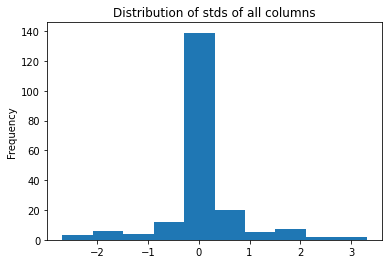

In [61]:
#данные не нормализованы, значения не от 0 до 1

# display(features.std()) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html

features.mean().plot(kind = 'hist', title ='Distribution of stds of all columns')


**распределены ли данные нормально?**

<AxesSubplot:title={'center':'Distribution of means of all columns'}, ylabel='Frequency'>

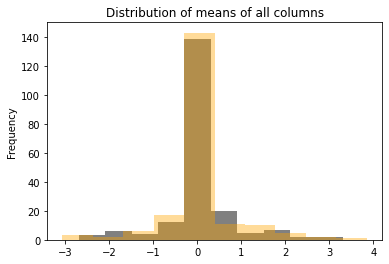

In [14]:
features.mean().plot(kind ='hist', title = 'Distribution of means of all columns',
                     color = 'gray')

features.median().plot(kind ='hist', title = 'Distribution of means of all columns',
                       color = 'orange', alpha = 0.4)

In [68]:
features.mean()

0     -0.220818
1     -0.015133
2      0.195772
3     -0.012546
4     -0.033779
         ...   
195    0.008210
196    0.811130
197   -0.004585
198    0.021731
199   -0.059244
Length: 200, dtype: float64

In [65]:
# проверим, что нет пустых значений
features.isnull().any().any() # добавление нового .any() уменьшает "размерность" проверяемого

# returns True if any item in an iterable are true, otherwise it returns False

False

In [67]:
#дисбаланс классов (можно регулировать в make_classification(weights=[0.7, 0.3])

answers[0].value_counts() # число в квадратных скобках - это индекс столбца, он у нас всего один

0    698
1    302
Name: 0, dtype: int64

### обучение

In [75]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42) 
# обратите внимание на test_size

In [74]:
np.mean(X_train, axis=0) # данные еще не нормированы, давайте это исправим

array([-1.87426779e-01,  2.13139084e-02,  1.57978299e-01, -3.42908394e-02,
       -2.17864582e-02, -3.67657764e-02, -2.22078708e-03,  2.11393049e-02,
       -2.40655656e+00, -6.74833884e-03,  4.86063443e-02,  1.96256604e+00,
       -1.38195214e-01, -3.72741378e-03, -1.54310055e-02, -1.12078794e-03,
        2.20427362e-01,  9.45288505e-01,  5.74485057e-03,  2.57017947e-01,
        5.30654479e-02, -5.63250535e-03,  2.80868616e-02, -7.56851861e-02,
        2.36954099e-02, -3.41519034e-01,  5.46992227e-01,  1.04065246e-02,
        1.48719665e-02,  7.08349379e-02, -7.69050539e-01,  4.10069702e-02,
        5.34940421e-01, -4.73598633e-02, -1.77484684e+00, -2.05880960e-02,
       -3.15467866e-02,  1.61816352e+00,  1.72991295e-01,  2.52490564e+00,
       -4.34188659e-02,  5.43980857e-02,  2.80098556e-02, -2.95294276e-02,
       -4.70938877e-01, -3.72537357e-02,  1.52826008e-01,  3.08811142e-01,
        7.49150015e-01, -3.64910067e-03, -3.69074356e-01, -5.76844399e-02,
        1.89118381e-02, -

Данные нормируют, потому что дисбаланс между значениями признаков может негативно сказаться работе модели и ухудшить результаты обучения.

In [19]:
#Нормируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
display(np.mean(X_test, axis=0).min())
display(np.mean(X_test, axis=0).max())

-3.660071461270674

3.44670429787743

In [79]:
display(np.mean(X_train, axis=0).min())
display(np.mean(X_train, axis=0).max())

-2.565033805358977

3.795739100869067

Теперь у нас есть матрица признаков и их значений(весов), вектор с финальными значениями, все нормировано, можно обучаться

In [72]:
# обучимся на том, что есть, и оценим качество предсказаний на трейне
model = linear_model.LogisticRegression()

model = model.fit(X_train, y_train)

train_preds = model.predict_proba(X_train)[:,1] # метод для предсказания вероятности класса

test_preds = model.predict_proba(X_test)[:, 1] 

In [84]:
test_preds

array([3.61641226e-01, 6.72246559e-01, 2.72603904e-02, 8.48894575e-01,
       2.21846566e-01, 6.52544546e-02, 1.37123487e-01, 6.27572800e-01,
       8.24385047e-01, 9.62159408e-01, 3.43975255e-04, 4.27278754e-02,
       6.28915431e-03, 5.35569996e-01, 8.34580020e-01, 1.07489304e-02,
       1.42210465e-03, 2.43167320e-02, 2.94340924e-01, 2.28732619e-01,
       9.83271093e-01, 9.41675309e-01, 1.72952508e-01, 1.35616359e-02,
       8.29169779e-02, 9.81869219e-01, 8.04729537e-02, 2.79462616e-03,
       1.02025109e-01, 1.06202160e-02, 8.22077535e-01, 3.83203928e-01,
       2.88267355e-02, 6.59226934e-01, 8.82439474e-01, 4.60217407e-01,
       8.53366286e-01, 8.26624887e-02, 3.76825907e-02, 1.47118973e-02,
       1.14431854e-01, 1.34180206e-02, 1.69930688e-01, 8.46207818e-02,
       3.17088122e-01, 6.27089494e-02, 4.98678477e-01, 8.30508512e-01,
       4.33349074e-01, 1.45408980e-02, 8.41571282e-03, 3.27629372e-02,
       5.17358323e-02, 3.83197151e-02, 7.77515588e-01, 3.58933040e-01,
      

In [92]:
pd.DataFrame(y_train)[:3]

,0
0,1
1,1
2,0


In [94]:
pd.DataFrame(model.predict(X_train))[:3] # 

# model.predict_proba(X_train)[:,1].shape

,0
0,1
1,1
2,0


Регрессия для классификации? Что? Да! ([как так](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F))

## как оценить примерное качество модели, если тест закрыт?

In [86]:
roc_auc_score(y_train, train_preds)

0.9058695652173914

In [87]:
roc_auc_score(y_test, test_preds)

0.7556179775280899

In [95]:
y_preds = model.predict(X_test)

пример из kaggle

In [88]:
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))

print('result on test: {}'.format(roc_auc_score(y_test, test_preds)))

result on train: 0.9058695652173914
result on test: 0.7556179775280899


In [96]:
print(accuracy_score(y_test, y_preds))

0.736


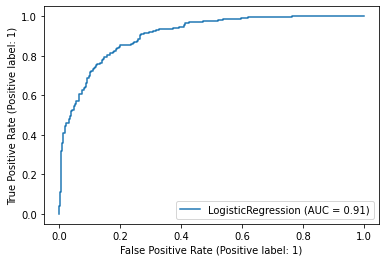

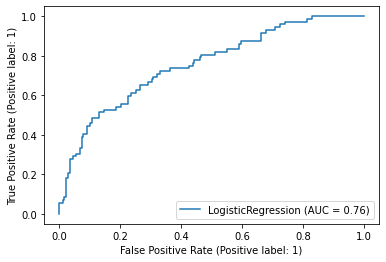

In [24]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model,X_train, y_train)

plot_roc_curve(model,X_test, y_test)

Чем выше показатель AUC, тем качественнее классификатор [что такое roc-auc](https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F)

### Как посмотреть, какие признаки в данных -- самые важные?

В некоторых моделях, например в деревьях решений, есть встроенный метод feature_importances_

In [97]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
train_preds = dtc.predict_proba(X_train)[:, 1]
test_preds = dtc.predict_proba(X_test)[:, 1]

print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))


result on train: 1.0
result on test: 0.6082240948813982


In [98]:
dtc.feature_importances_

array([0.01488478, 0.00470318, 0.01505017, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01527737, 0.03363128, 0.00537506, 0.        , 0.        ,
       0.0083612 , 0.02887027, 0.        , 0.        , 0.00895843,
       0.0102619 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00604765, 0.        , 0.        ,
       0.01761575, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00752508,
       0.00614548, 0.        , 0.        , 0.00470318, 0.00470318,
       0.00597229, 0.        , 0.        , 0.02231266, 0.00614539,
       0.        , 0.        , 0.        , 0.00501672, 0.        ,
       0.02475806, 0.00775814, 0.        , 0.04561875, 0.        ,
       0.        , 0.        , 0.01827827, 0.        , 0.        ,
       0.01115988, 0.00610142, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01003344, 0.        , 0.     

In [101]:
feature_importance = pd.DataFrame()

feature_importance["feature"] = features.columns
feature_importance["importance"] = dtc.feature_importances_

feature_importance[["feature", "importance"]].sort_values(by = 'importance', ascending = False)[:50]

,feature,importance
168,168,0.048485
58,58,0.045619
105,105,0.045266
11,11,0.033631
108,108,0.033377
197,197,0.030638
16,16,0.028870
119,119,0.028210
159,159,0.025205
55,55,0.024758
